In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from helpers import import_raw_data

data = import_raw_data()

In [3]:
data.Study = data.Study.str.lower().str.strip()
data.API = data.API.str.lower().str.strip()
data.Pgp = data.Pgp.str.lower().str.strip()
data.Position = data.Position.str.lower().str.strip()
data.Comp1 = data.Comp1.str.lower().str.strip()
data.Comp2 = data.Comp2.str.lower().str.strip()
data.CarrierNature = data.CarrierNature.str.lower().str.strip()
data.Preparation = data.Preparation.str.lower().str.strip()
data.Solvent = data.Solvent.str.lower().str.strip()
data.Stabilizer = data.Stabilizer.str.lower().str.strip()
data.Separation = data.Separation.str.lower().str.strip()
data.Ligands = data.Ligands.str.lower().str.strip()
data.NPShape = data.NPShape.str.lower().str.strip()
data.Route = data.Route.str.lower().str.strip()
data.logP = pd.to_numeric(data.logP)
data.pKa = pd.to_numeric(data.pKa)

In [4]:
temp = data.copy()
y = temp['AUC']
X = temp.drop(['AUC'], axis=1)

from category_encoders import TargetEncoder

X.applymap(lambda x : x.strip() if isinstance(x, str) else x)
X['Pgp'].replace(['no', 'yes'], [0, 1], inplace=True)
X['Position'].replace(['core', 'matrix'], [0, 1], inplace=True)
enc = TargetEncoder(cols=['Comp1', 'Comp2', 'Route'])
X = enc.fit_transform(X, y)

from scipy import stats

t_y, l = stats.boxcox(y)
# t_y = y
data1 = X.copy()
data1['AUC'] = t_y

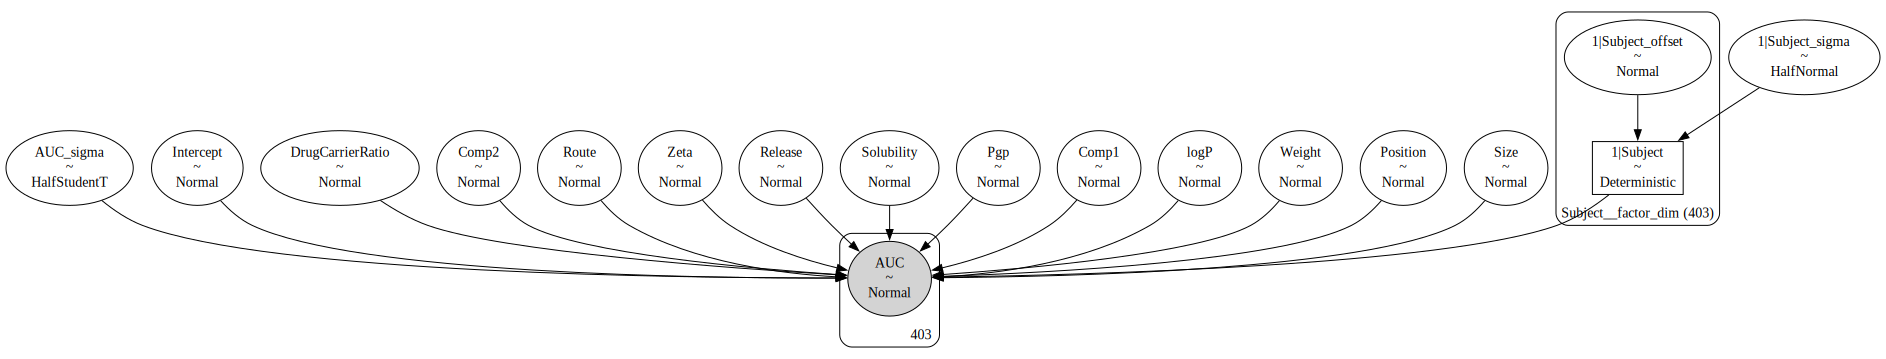

In [5]:
import bambi as bmb

formula = "AUC ~ Weight + logP + Solubility + Pgp + DrugCarrierRatio + Position + Comp1 + Comp2 + Size + Zeta + Release + Route + (1|Subject)"
model_bmb = bmb.Model(formula, data1)
model_bmb.build()
model_bmb.graph(name='multiplereg', figsize=(12,12))

In [6]:
fitted_hier_glm = model_bmb.fit(10000, tune=10000, target_accept=.95, random_seed=42)
az.summary(fitted_hier_glm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AUC_sigma, Intercept, Weight, logP, Solubility, Pgp, DrugCarrierRatio, Position, Comp1, Comp2, Size, Zeta, Release, Route, 1|Subject_sigma, 1|Subject_offset]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 231 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1660 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.775,0.795,-7.232,-4.251,0.009,0.006,8184.0,8023.0,1.00
Weight,-0.000,0.000,-0.000,-0.000,0.000,0.000,6741.0,4427.0,1.00
logP,-0.074,0.021,-0.114,-0.035,0.000,0.000,6004.0,4134.0,1.00
Solubility,-0.001,0.002,-0.004,0.002,0.000,0.000,9480.0,11936.0,1.00
Pgp,-0.077,0.153,-0.356,0.218,0.002,0.001,6974.0,11892.0,1.00
...,...,...,...,...,...,...,...,...,...
1|Subject[398],-0.141,0.552,-1.222,0.915,0.008,0.006,4404.0,12064.0,1.00
1|Subject[399],-0.400,0.605,-1.591,0.663,0.045,0.032,185.0,6107.0,1.02
1|Subject[400],-0.220,0.556,-1.300,0.864,0.013,0.009,1467.0,8030.0,1.01
1|Subject[401],-0.343,0.586,-1.498,0.693,0.037,0.026,252.0,9869.0,1.02


In [25]:
test = pd.DataFrame(
        {'Subject': [0, 1, 2, 3], 'Weight': [252.268, 252.268, 252.268, 252.268], 'logP': [2.260, 2.260, 2.260, 2.260],
         'Solubility': [0.071, 0.071, 0.071, 0.071], 'Pgp': [1, 1, 1, 1],
         'DrugCarrierRatio': [0.480, 0.480, 0.480, 0.480], 'Position': [0, 0, 0, 0],
         'Comp1': [2.34761, 2.34761, 2.34761, 2.34761], 'Comp2': [2.383959, 2.286618, 2.383959, 2.286618],
         'Size': [170.630, 453.100, 170.630, 453.100], 'Zeta': [-37.700, 33.400, -37.700, 33.400],
         'Release': [2.26, 2.95, 2.26, 2.95], 'Route': [2.65484, 2.65484, 1.532931, 1.532931],
         'AUC': stats.boxcox([1.03, 2.96, 0.365, 0.614], lmbda=l)})

<AxesSubplot: xlabel='AUC / AUC'>

/Users/introvertuoso/python3.10_venv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/introvertuoso/python3.10_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


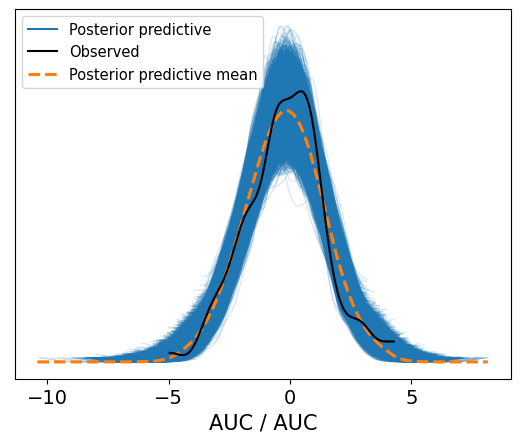

In [8]:
posterior_predictive_hier_glm_ = model_bmb.predict(fitted_hier_glm, kind="pps", data=data1)
az.plot_ppc(fitted_hier_glm)

In [9]:
y_pred = fitted_hier_glm['posterior_predictive']['AUC'].values.mean(axis=0).mean(axis=0)
mse = sum((data1['AUC'].values - y_pred)**2)/len(data1['AUC'].values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5654175201126687


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'Weight'}>,
        <AxesSubplot: title={'center': 'Weight'}>],
       [<AxesSubplot: title={'center': 'logP'}>,
        <AxesSubplot: title={'center': 'logP'}>],
       [<AxesSubplot: title={'center': 'Solubility'}>,
        <AxesSubplot: title={'center': 'Solubility'}>],
       [<AxesSubplot: title={'center': 'Pgp'}>,
        <AxesSubplot: title={'center': 'Pgp'}>],
       [<AxesSubplot: title={'center': 'DrugCarrierRatio'}>,
        <AxesSubplot: title={'center': 'DrugCarrierRatio'}>],
       [<AxesSubplot: title={'center': 'Position'}>,
        <AxesSubplot: title={'center': 'Position'}>],
       [<AxesSubplot: title={'center': 'Comp1'}>,
        <AxesSubplot: title={'center': 'Comp1'}>],
       [<AxesSubplot: title={'center': 'Comp2'}>,
        <AxesSubplot: title={'center': 'Comp2'}>],
       [<AxesSubplot: title={'center': 'Size'}>,


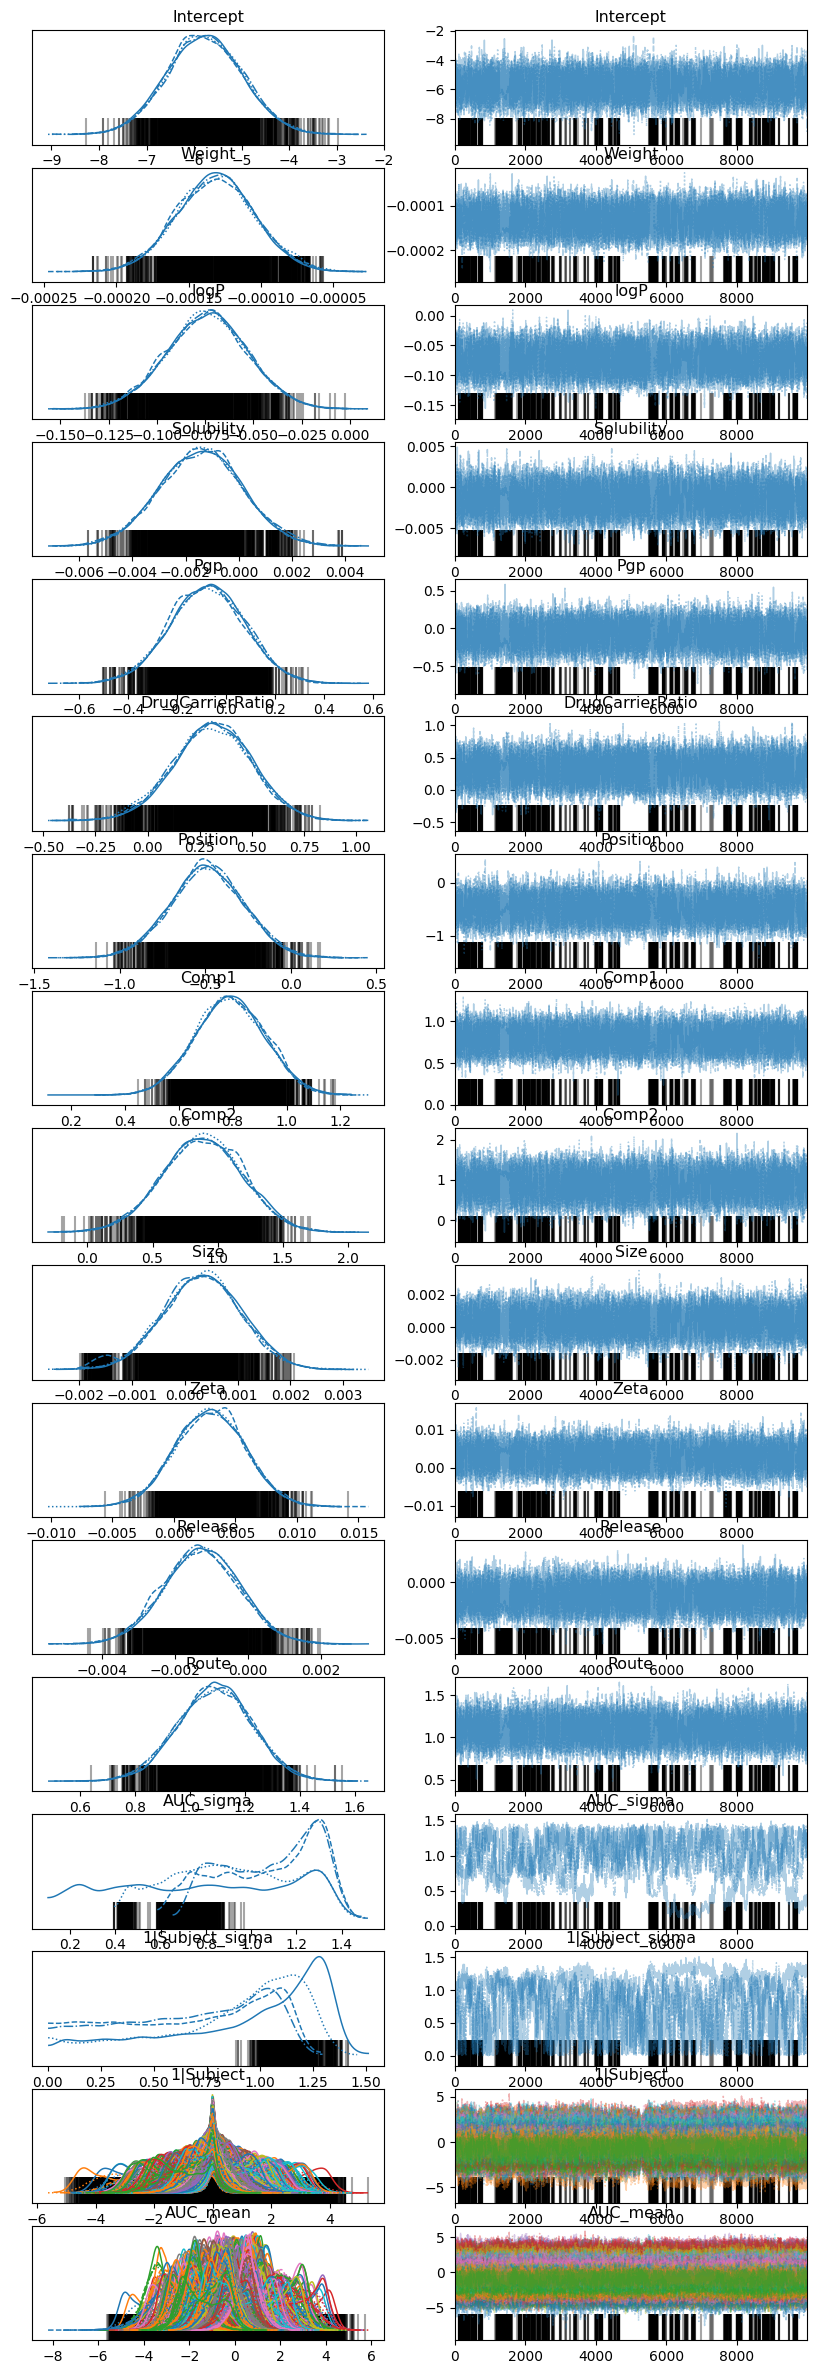

In [10]:
az.plot_trace(fitted_hier_glm, figsize=(10, 30))

Sampling: [1|Subject_sigma, AUC_sigma, Comp1, Comp2, DrugCarrierRatio, Intercept, Pgp, Position, Release, Route, Size, Solubility, Weight, Zeta, logP]


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'AUC_sigma'}>,
        <AxesSubplot: title={'center': 'Weight'}>],
       [<AxesSubplot: title={'center': 'logP'}>,
        <AxesSubplot: title={'center': 'Solubility'}>,
        <AxesSubplot: title={'center': 'Pgp'}>],
       [<AxesSubplot: title={'center': 'DrugCarrierRatio'}>,
        <AxesSubplot: title={'center': 'Position'}>,
        <AxesSubplot: title={'center': 'Comp1'}>],
       [<AxesSubplot: title={'center': 'Comp2'}>,
        <AxesSubplot: title={'center': 'Size'}>,
        <AxesSubplot: title={'center': 'Zeta'}>],
       [<AxesSubplot: title={'center': 'Release'}>,
        <AxesSubplot: title={'center': 'Route'}>,
        <AxesSubplot: title={'center': '1|Subject_sigma'}>]], dtype=object)

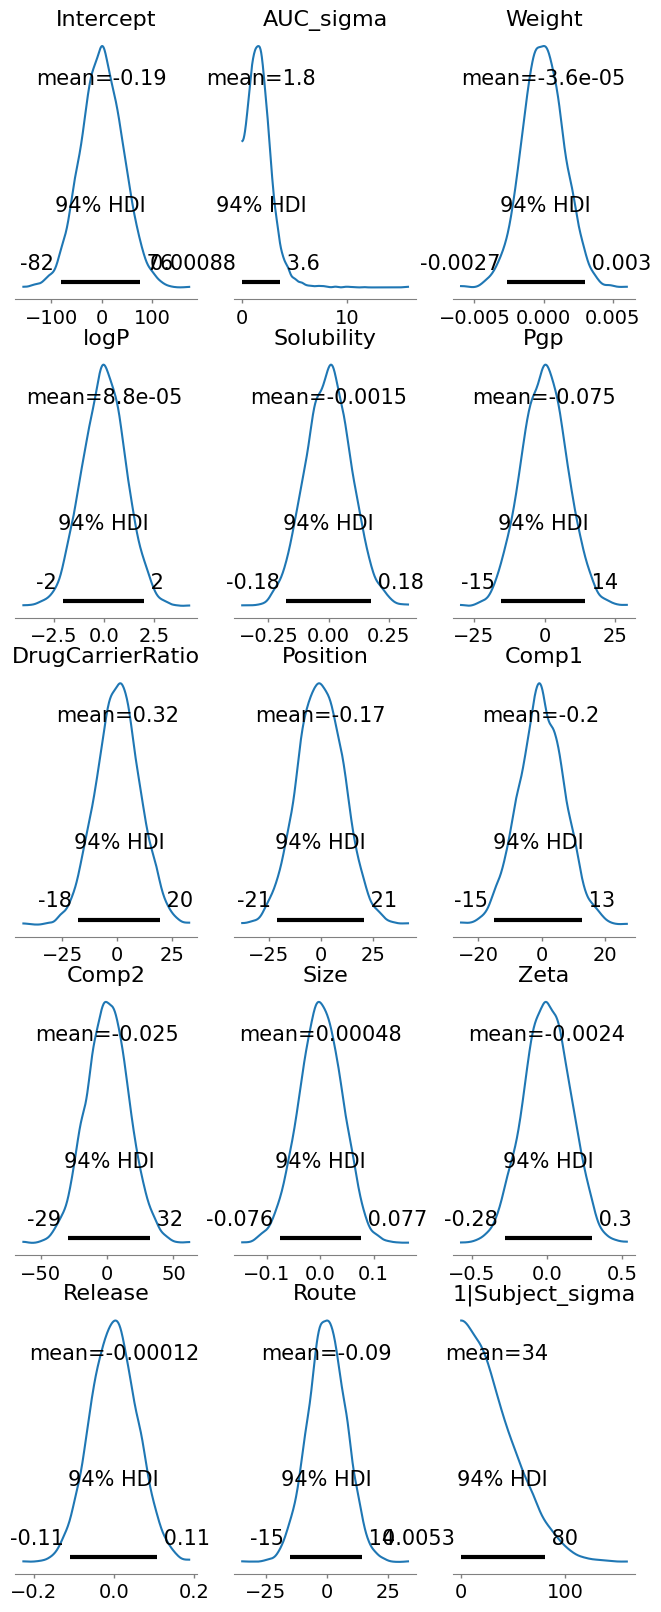

In [11]:
model_bmb.plot_priors(figsize=(8, 20))

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

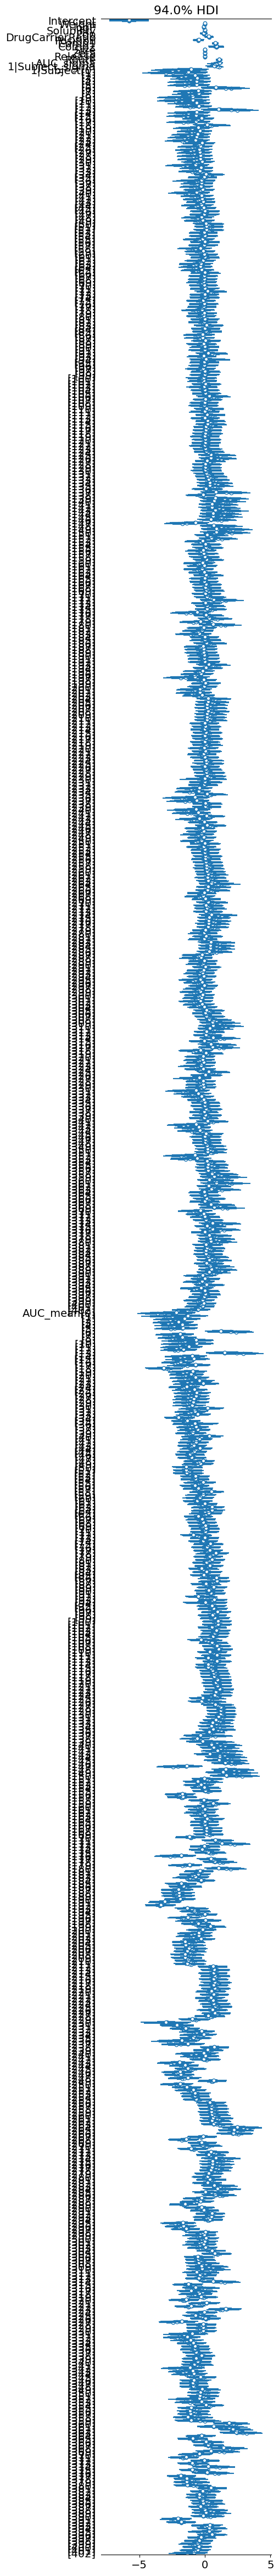

In [12]:
az.plot_forest(fitted_hier_glm, figsize=(4, 60))

/Users/introvertuoso/python3.10_venv/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (821) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Weight'}>,
        <AxesSubplot: title={'center': 'logP'}>,
        <AxesSubplot: title={'center': 'Solubility'}>],
       [<AxesSubplot: title={'center': 'Pgp'}>,
        <AxesSubplot: title={'center': 'DrugCarrierRatio'}>,
        <AxesSubplot: title={'center': 'Position'}>,
        <AxesSubplot: title={'center': 'Comp1'}>],
       [<AxesSubplot: title={'center': 'Comp2'}>,
        <AxesSubplot: title={'center': 'Size'}>,
        <AxesSubplot: title={'center': 'Zeta'}>,
        <AxesSubplot: title={'center': 'Release'}>],
       [<AxesSubplot: title={'center': 'Route'}>,
        <AxesSubplot: title={'center': 'AUC_sigma'}>,
        <AxesSubplot: title={'center': '1|Subject_sigma'}>,
        <AxesSubplot: title={'center': '1|Subject\n0'}>],
       [<AxesSubplot: title={'center': '1|Subject\n1'}>,
        <AxesSubplot: title={'center': '1|Subject\n2'}>,
        <AxesSubplot: title={'center': '

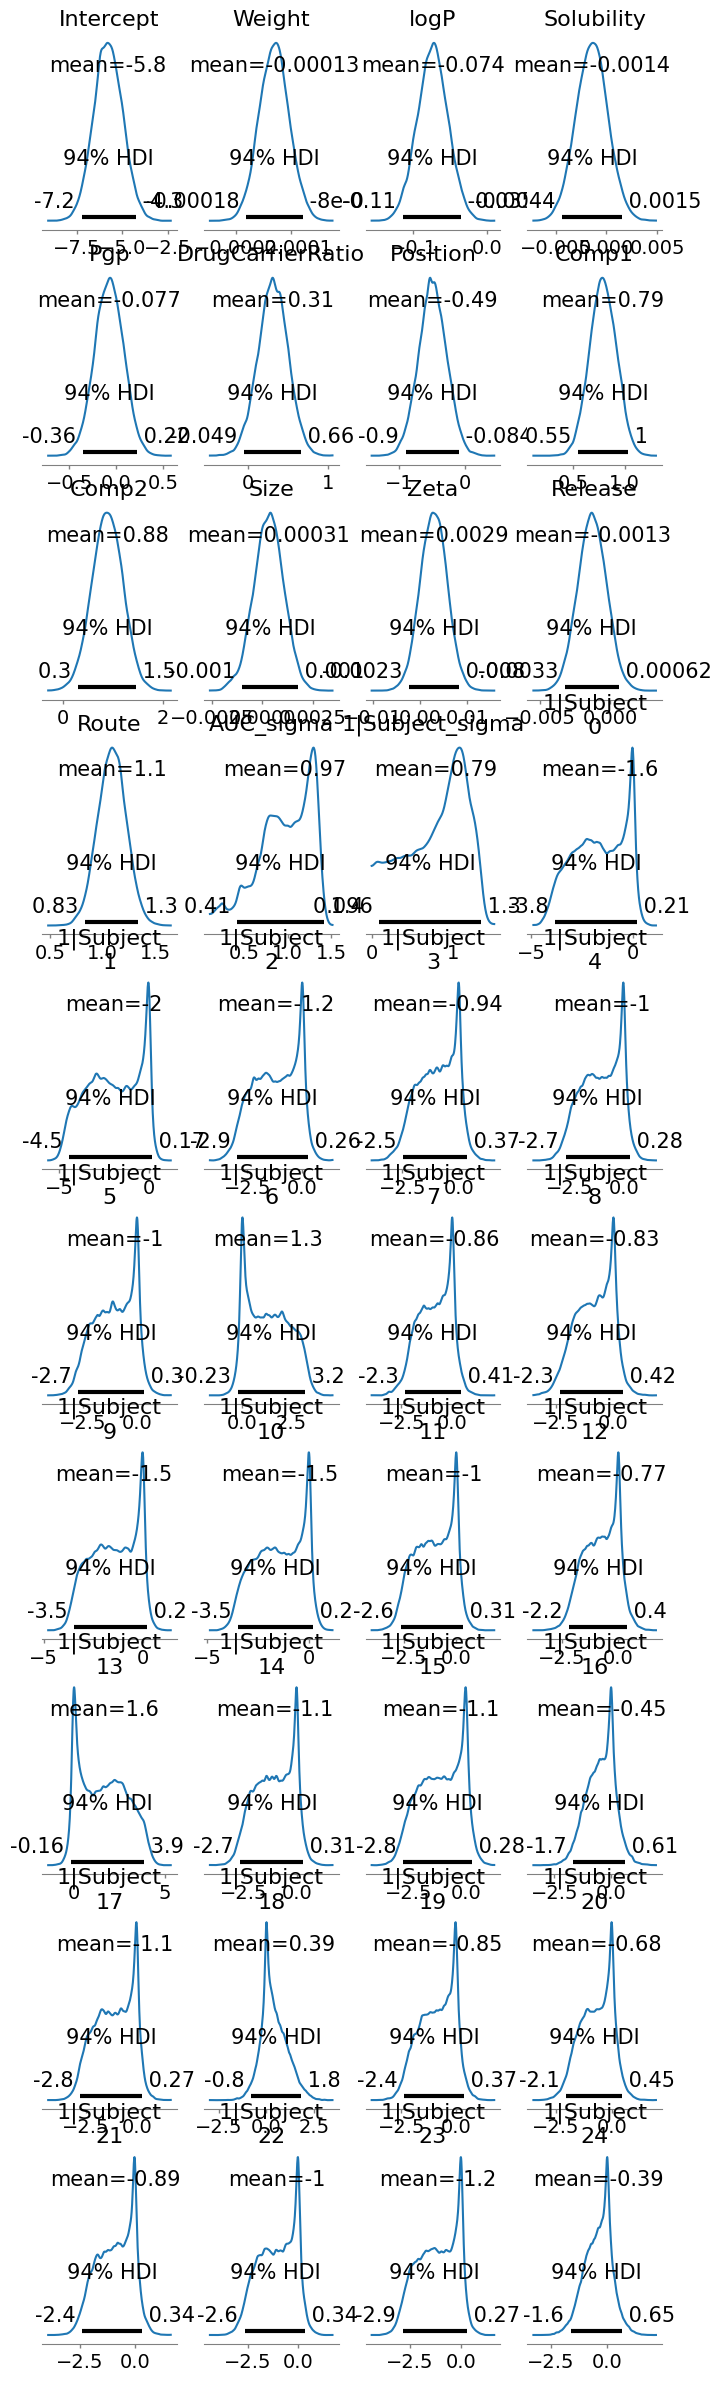

In [13]:
az.plot_posterior(fitted_hier_glm, figsize=(8, 30))

In [20]:
import statsmodels.api as sm

# the names of the predictors
varnames = ['Weight', 'logP', 'Solubility', 'Pgp', 'DrugCarrierRatio', 'Position', 'Comp1', 'Comp2', 'Size', 'Zeta', 'Release', 'Route']

# compute the needed statistics like R-squared when each predictor is response and all the
# other predictors are the predictor

# x_matrix = common effects design matrix (excluding intercept/constant term)
terms = [t for t in model_bmb.response_component.common_terms.values() if t.name != "Intercept"]
x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)
x_matrix.columns = varnames

dm_statistics = {
    'r2_x': pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in model_bmb.response_component.terms
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    'sigma_x': x_matrix.std(),
    'mean_x': x_matrix.mean(axis=0),
}

r2_x = dm_statistics['r2_x']
sd_x = dm_statistics['sigma_x']
r2_y = pd.Series([sm.OLS(endog=data1['AUC'],
                         exog=sm.add_constant(data1[[p for p in varnames if p != x]])).fit().rsquared
                  for x in varnames], index=varnames)
sd_y = data['AUC'].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant

Weight              737.562237
logP                  0.950810
Solubility           12.596148
Pgp                   0.132662
DrugCarrierRatio      0.106812
Position              0.091746
Comp1                 0.148321
Comp2                 0.064399
Size                 27.739892
Zeta                  7.146536
Release              19.426802
Route                 0.136925
dtype: float64

In [21]:
samples = fitted_hier_glm.posterior
pcorr_samples = (samples[varnames] * slope_constant)

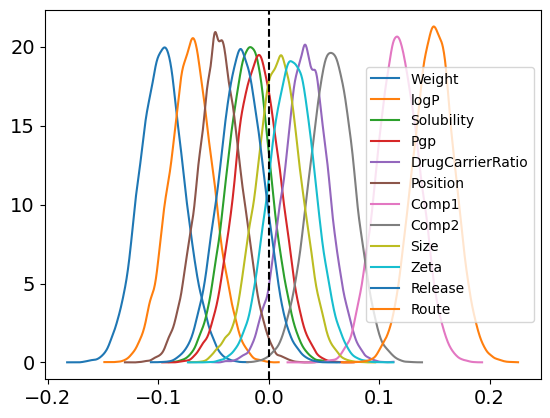

In [22]:
# Pass the same axes to az.plot_kde to have all the densities in the same plot
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_dist(v, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.axvline(x=0, color='k', linestyle='--');

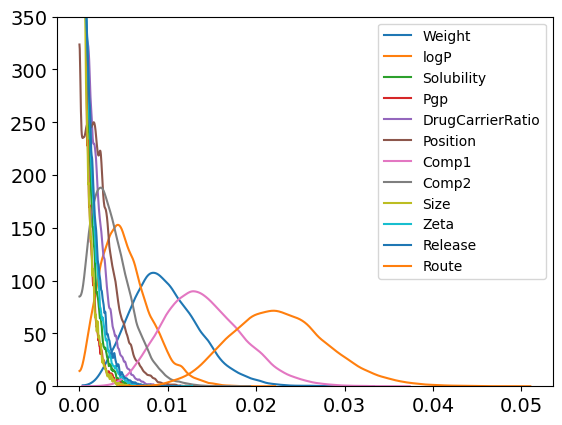

In [23]:
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_dist(v ** 2, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.set_ylim(0, 350);

<AxesSubplot: xlabel='AUC / AUC'>

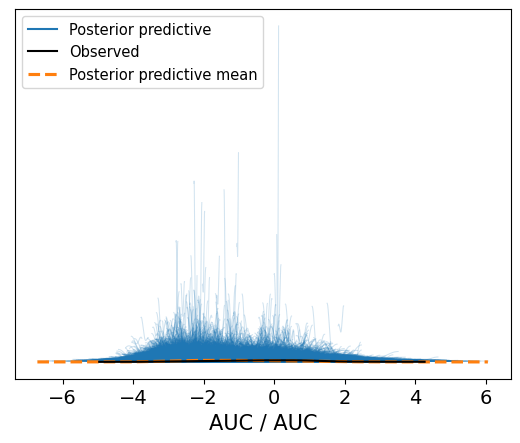

In [26]:
posterior_predictive_hier_glm_ = model_bmb.predict(fitted_hier_glm, kind="pps", data=test)
az.plot_ppc(fitted_hier_glm)

In [27]:
y_pred = fitted_hier_glm['posterior_predictive']['AUC'].values.mean(axis=0).mean(axis=0)
mse = sum((test['AUC'].values - y_pred)**2)/len(test['AUC'].values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.3419706650032674


In [28]:
y_pred

array([-0.75943516, -0.86729488, -1.52644428, -1.0560158 ])

In [29]:
true = test['AUC']
true

0    0.029607
1    1.152591
2   -0.954017
3   -0.474911
Name: AUC, dtype: float64

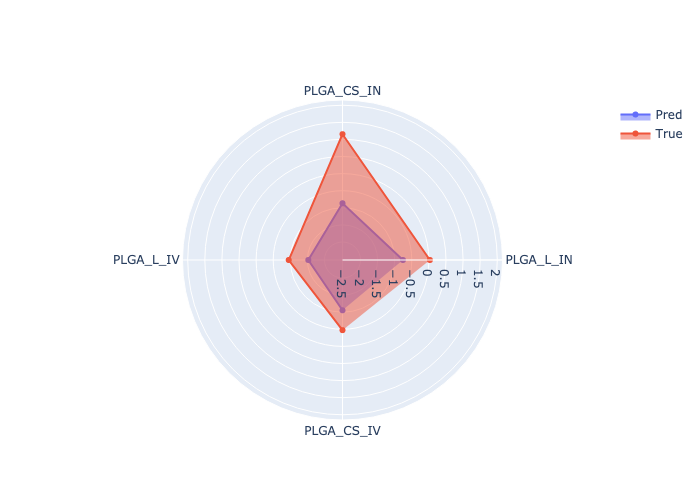

In [30]:
from helpers import radar_graph

radar_graph(true, y_pred)